**Topic Labeling**

Topic labeling, also known as topic classification, is the process of assigning one or more predefined labels or categories to a given text document based on its content. The aim of topic labeling is to help organize and manage large volumes of textual data by providing a way to quickly categorize and retrieve relevant information.
Topic labeling is widely used in various applications such as information retrieval, content recommendation, and sentiment analysis.

For this experiment, I use BBC News dataset which consists of 2225 news articles separated by 5 different topics business, entertainment, politics, sports and technology. The objective of Topic Labeling on BBC News Articles is to identify and extract the hidden topics from a collection of News articles from BBC News, using Natural Language Processing(NLP) and Machine learning techniques.

# Import libraries

In [ ]:
%%capture
!pip install datasets nltk PyTorch torch tensorflow numpy scikit-learn matplotlib seaborn wordcloud

In [ ]:
%%capture
!pip install sentencepiece tensorflow transformers autocorrect

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from transformers import BertTokenizer, XLNetTokenizer, DistilBertTokenizer, BertForSequenceClassification, XLNetForSequenceClassification, DistilBertForSequenceClassification, AutoModelForSequenceClassification, TFAutoModel, TFAutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, AdamW
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from autocorrect import Speller
spell = Speller(lang='en')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from functools import reduce
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from time import time


In [ ]:
class Path:
    BASE = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'BBC classification')
    DATA = os.path.join(BASE, 'data')
    # DATA = "https://raw.githubusercontent.com/parvaneh-soleimany/Topic_labeling_bbc_news/main/data/bbc.csv"
    MODELS = os.path.join(BASE, 'models')
    TRANSFORMER_MODELS = os.path.join(MODELS, 'transformer')
    FINE_TUNED_MODELS = os.path.join(MODELS, 'fine_tuned')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Data preparation

In [ ]:
dataset_df = pd.read_csv(os.path.join(Path.DATA, 'bbc.csv'), sep = ',')
# dataset_df = pd.read_csv(Path.DATA, sep = ',')
print(f"Dataset shape: {dataset_df.shape}")

Dataset shape: (2225, 2)


In [ ]:
dataset_df.iloc[:10]

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


I will include a new column in the dataset that serves as a label, indicating the category for each entry.

In [ ]:
possible_labels = dataset_df['category'].unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'tech': 0, 'business': 1, 'sport': 2, 'entertainment': 3, 'politics': 4}

In [ ]:
dataset_df['label'] = dataset_df['category'].replace(label_dict)

In [ ]:
dataset_df.iloc[:10]

,category,text,label
0,tech,tv future in the hands of viewers with home th...,0
1,business,worldcom boss left books alone former worldc...,1
2,sport,tigers wary of farrell gamble leicester say ...,2
3,sport,yeading face newcastle in fa cup premiership s...,2
4,entertainment,ocean s twelve raids box office ocean s twelve...,3
5,politics,howard hits back at mongrel jibe michael howar...,4
6,politics,blair prepares to name poll date tony blair is...,4
7,sport,henman hopes ended in dubai third seed tim hen...,2
8,sport,wilkinson fit to face edinburgh england captai...,2
9,entertainment,last star wars not for children the sixth an...,3


# A bit of statistics
Before diving head-first into training models, we should become familiar with the structure and characteristics of our dataset: these properties might inform our problem-solving approach.

In [ ]:
#function to group data by categories
def group(df,column):
  groupped_Category=df.groupby([column]).agg({column:'count'})
  groupped_Category.rename({column:'count_of_categories'},axis=1,inplace=True)
  groupped_Category=groupped_Category.reset_index()
  return groupped_Category


In [ ]:
def Barplot(category,values):
  fig = go.Figure([go.Bar(x=category,y=values,)])
  fig.update_layout(title_text='Categorical counts', yaxis_title ='Count',
                  xaxis_title='Categories',
                  xaxis={'categoryorder':'total ascending'})
  fig.show()

In [ ]:
def pieplot(category,values):
  fig = make_subplots(rows=1,cols=2,specs=[[{'type':'domain'},{'type':'domain'}]])
  fig.add_trace(go.Pie(labels=category,
                     values=values,),
                     row=1,col= 1)
  fig.show()

In [ ]:
groupped_Category=group(dataset_df,'category')
groupped_Category

,category,count_of_categories
0,business,510
1,entertainment,386
2,politics,417
3,sport,511
4,tech,401


In [ ]:
Barplot(groupped_Category.category,groupped_Category.count_of_categories)

In [ ]:
pieplot(groupped_Category.category,groupped_Category.count_of_categories)

Here, we see that the number of articles per class is roughly balanced, which is helpful! If our dataset were imbalanced, we would need to carefully configure our model or artificially balance the dataset, for example by undersampling or oversampling each class.

I splitted the dataset to three distinct part consisting train (70%), validation (15%) and test (15%).

In [ ]:
# Using the stratification sampling method to split data to ensure representative distributions and minimizing biases.
train_df,valid_df= train_test_split(dataset_df,
                                     random_state=42,
                                     train_size=0.70,
                                     stratify=dataset_df.label.values,
                                     shuffle=True)
train_df.shape,valid_df.shape


((1557, 3), (668, 3))

In [ ]:
valid_df,test_df= train_test_split(valid_df,
                                   random_state=42,
                                   train_size=0.50,
                                   stratify=valid_df.label.values,
                                   shuffle=True)
valid_df.shape,test_df.shape

((334, 3), (334, 3))

Here I visualize classes distribution again, after splliting with stratification sampling method to ensure the distribution is preserved.



In [ ]:
groupped_Category_vaild=group(valid_df,'category')
groupped_Category_train=group(train_df,'category')

In [ ]:
pieplot(groupped_Category_vaild.category,groupped_Category_vaild.count_of_categories)
pieplot(groupped_Category_train.category,groupped_Category_train.count_of_categories)

<Axes: >

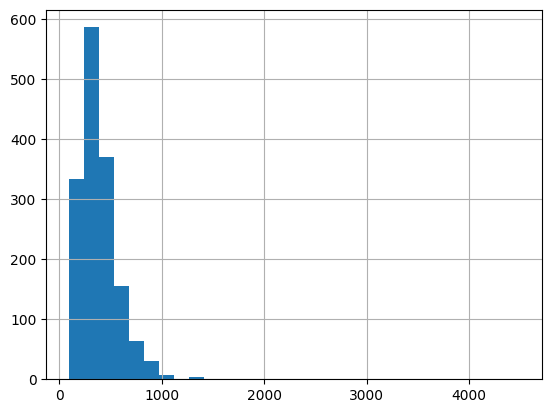

In [ ]:
#list of words count in each sentence
seq_len = [len(i.split()) for i in train_df['text']]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
import plotly.express as px
#df = px.data.tips()
fig = px.histogram(x=seq_len,nbins=30)
fig.show()



In this part I show a snapshot of the most common words in the text (before preprocessing)

In [ ]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 55.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})

    fig = plt.figure(figsize=(21,16))
    ax1 = fig.add_subplot(2,1,1)
    wordcloud = WordCloud(width=1000, height=300, background_color='black',
                          max_words=1628, relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False).generate_from_frequencies(freq_dist)

    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')

    # select top 20 most frequent word
    ax2 = fig.add_subplot(2,1,2)
    d = words_df.nlargest(columns="count", n = terms)
    ax2 = sns.barplot(data=d, palette = sns.color_palette('BuGn_r'), x= "count", y = "word")
    ax2.set(ylabel= 'Word')
    plt.show()

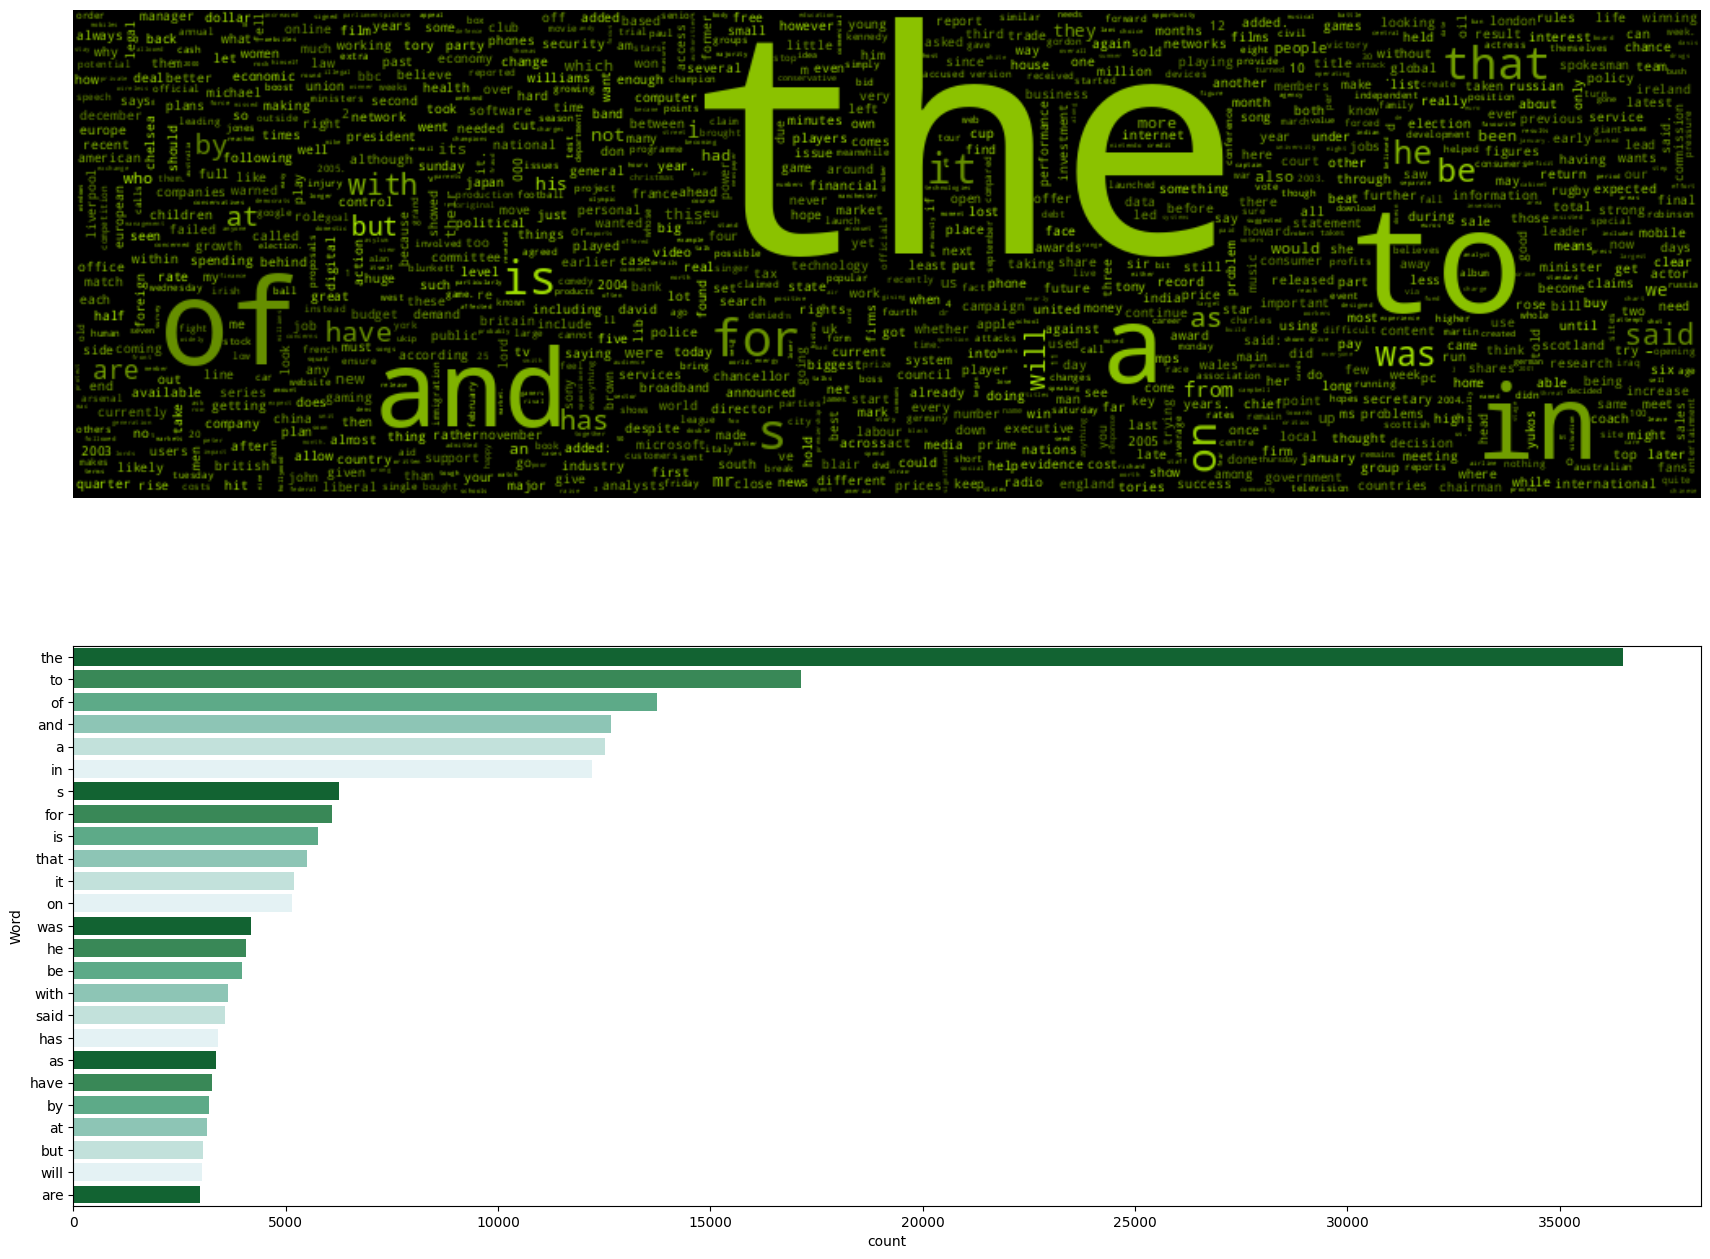

In [ ]:
# plot 25 most frequent words including stop words
freq_words(train_df['text'], 25)

As it is clear, stop words are the most significant words in our dataset, which negetively affect the performance of our models. Stop words often do not contribute to the context or semantic meaning of a sentence. Removing them allows for a more focused analysis of the remaining words. In the following steps, we do some preprocessing including removal of the stop words from the text.

The plot of 25 frequent words showed that the top frequent words are actually stop-words and short-length words. So the cleaning of news articles includes removal of stop-words, short-length words and other unnecessary elements. In addition Lemmatization is also performed to reduce each word to their root form so that they can be grouped together while modeling.


**Pre-processing**

In [ ]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):

    nltk.download('wordnet')
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in
                    lst_stopwords]

    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
nltk.download('stopwords')
lst_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_df['text'] = train_df.text.apply(lambda x:
          preprocess_text(x, flg_stemm=False, flg_lemm=True,
          lst_stopwords=lst_stopwords))

valid_df['text'] = valid_df.text.apply(lambda x:
          preprocess_text(x, flg_stemm=False, flg_lemm=True,
          lst_stopwords=lst_stopwords))

test_df['text'] = test_df.text.apply(lambda x:
          preprocess_text(x, flg_stemm=False, flg_lemm=True,
          lst_stopwords=lst_stopwords))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downlo

After doing preprocessing step we can see the stop words are not the majority of our data any more. (see the word cloud)

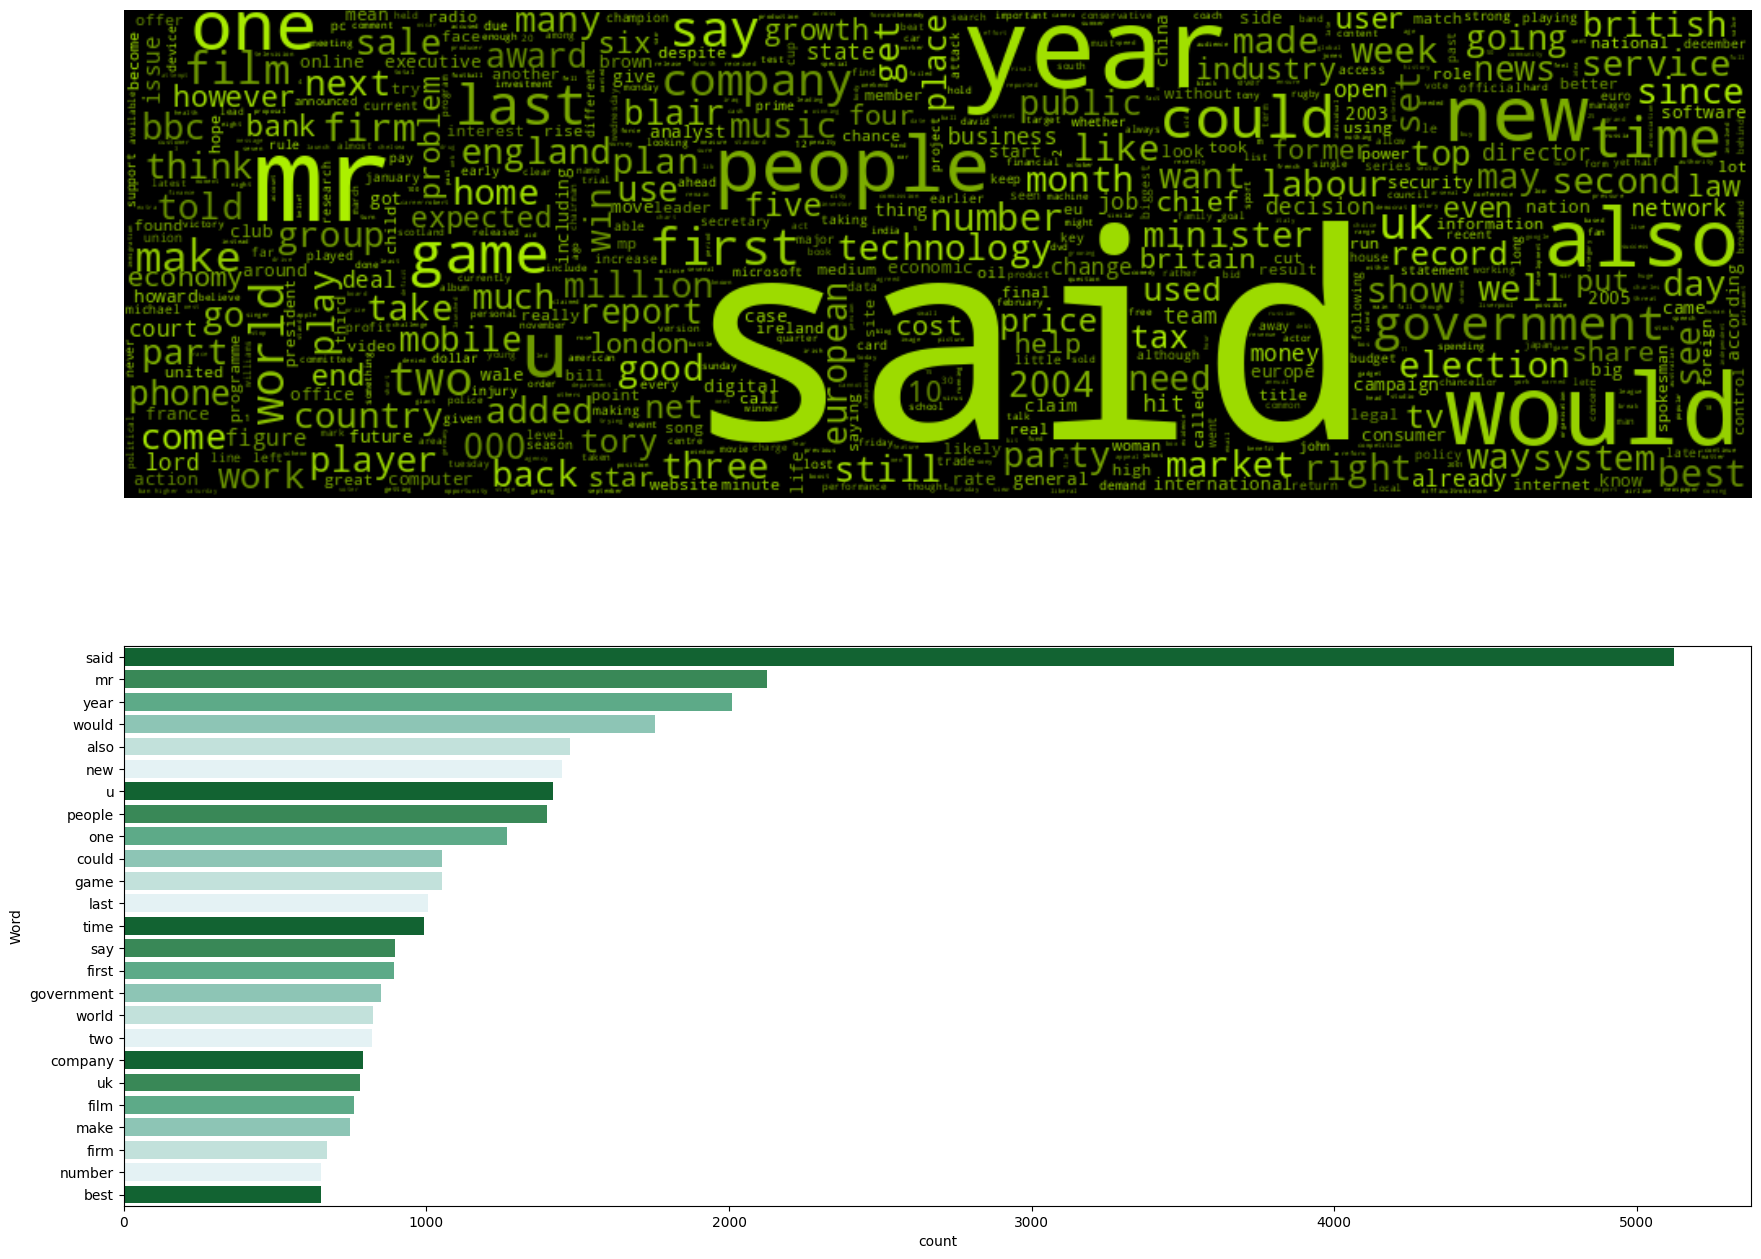

In [ ]:
# plot 25 most frequent words without stopwords
freq_words(train_df['text'], 25)

# Common functions

For evaluation of the models, I used different metrics consisting of Accuracy, Precision, Recall and F1 score.

In [ ]:
def calculate_metrics(true_label, prediction):
  f1_macro = f1_score(true_label, prediction, zero_division=0, average='macro')
  precision = precision_score(true_label, prediction, average='macro')
  recall = recall_score(true_label, prediction, average='macro')
  accuracy = accuracy_score(true_label, prediction)
  return accuracy, precision, recall, f1_macro

In [ ]:
def plot_metrics(accuracies, precisions, recalls, f1s, labels):
  cmp_fig, cmp_ax = plt.subplots(figsize=(8.0, 5.5))

  a = cmp_ax.bar(np.arange(3) + (1 * 0.1), accuracies, 0.1, color='c')
  p = cmp_ax.bar(np.arange(3) + (2 * 0.1), precisions, 0.1, color='r')
  r = cmp_ax.bar(np.arange(3) + (3 * 0.1), recalls, 0.1, color='g')
  f = cmp_ax.bar(np.arange(3) + (4 * 0.1), f1s, 0.1, color='m')

  cmp_ax.set_ylabel('Performance metrics')
  cmp_ax.set_title('Performance comparison')

  cmp_ax.set_xticks(np.arange(3) + 0.1)
  cmp_ax.set_ylim([0.8, 1.0])

  cmp_ax.set_xticklabels(labels)

  cmp_ax.legend((a[0], p[0], r[0], f[0]),
                ('Accuracy','Precision', 'Recall','F1 (Macro)'), loc='lower right')

In [ ]:
lengths = train_df['text'].apply(lambda x: x.split(" ")).apply(len)
length = int(lengths.quantile(0.99))
print('99 Percentile of text length is: ', length)

99 Percentile of text length is:  518


In [ ]:
bert_model_name = 'bert-base-uncased'
distilbert_model_name = 'distilbert-base-uncased'
xlnet_model_name = 'xlnet-base-cased'

# Machine Learning part


For the ML part of the project, Vectorization has been performed using TF-IDF vectorizer.

Three distinct ML models are implemented: SVM, Multinomial Naive Bayes and Logistic Regression

In [ ]:
ml_accuracies = []
ml_precisions = []
ml_recalls = []
ml_f1s= []

#create list of model and accuracy dicts
perform_list = []
def run_estimator(estimator, model_name):

    df_train = train_df.reset_index(drop=True)
    df_valid = valid_df.reset_index(drop=True)
    df_test  = test_df.reset_index(drop=True)

    x_train = df_train.text
    x_valid = df_valid.text
    x_test  = df_test.text
    y_train = df_train.label
    y_valid = df_valid.label
    y_test  = df_test.label

    tfv = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 1), stop_words='english')
    tfv.fit(x_train)

    x_train = tfv.transform(x_train)
    x_valid = tfv.transform(x_valid)
    x_test  = tfv.transform(x_test)

    estimator.fit(x_train, y_train)

    y_pred = estimator.predict(x_valid)
    df_valid.loc[:, str(model_name)+'_pred'] = y_pred

    y_test_pred = estimator.predict(x_test)
    df_test.loc[:, str(model_name)+'_test_pred'] = y_test_pred

    # Performance metrics
    accuracy, precision, recall, f1 = calculate_metrics(y_test, y_test_pred)
    ml_accuracies.append(accuracy)
    ml_precisions.append(precision)
    ml_recalls.append(recall)
    ml_f1s.append(f1)

    print(f'Accuracy  : {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1        : {f1}')

    # Add performance parameters to list
    perform_list.append(dict([
    ('Model', model_name),
    ('Accuracy', round(accuracy, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

    return df_valid, df_test

In [ ]:
models = [('LR', LogisticRegression(n_jobs=-1)),
           ('MultinomialNB', MultinomialNB()),
           ('SVM', SVC())]

In [ ]:
for (model_name, model) in models:
    print(30*'='+'  '+model_name+'  '+'='*30)
    run_estimator(model_name=model_name, estimator=model)

==============================  LR  ==============================
Accuracy  : 0.9820359281437125
Precision : 0.9819583333333334
Recall    : 0.9830512498254433
F1        : 0.9824227234753551
==============================  MultinomialNB  ==============================
Accuracy  : 0.9700598802395209
Precision : 0.9697368421052632
Recall    : 0.968407273112501
F1        : 0.9684284175745276
==============================  SVM  ==============================
Accuracy  : 0.9820359281437125
Precision : 0.9819583333333334
Recall    : 0.9830512498254433
F1        : 0.9824227234753551


In [ ]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Accuracy,Precision,Recall,F1
0,LR,0.98,0.98,0.98,0.98
1,MultinomialNB,0.97,0.97,0.97,0.97
2,SVM,0.98,0.98,0.98,0.98


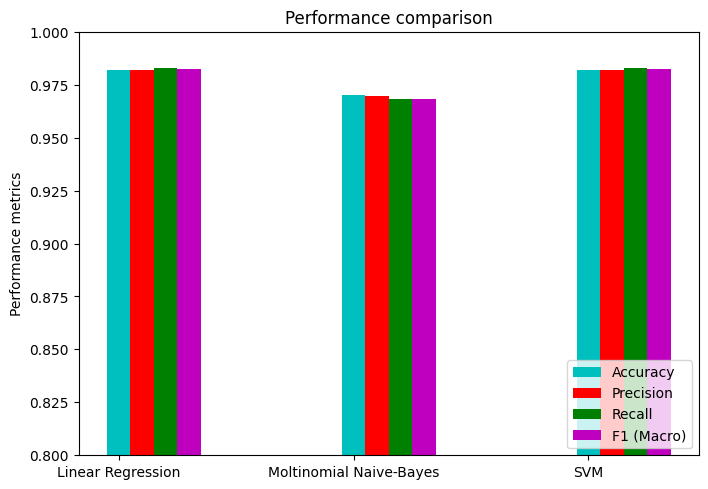

In [ ]:
plot_metrics(ml_accuracies, ml_precisions, ml_recalls, ml_f1s, ('Linear Regression', 'Moltinomial Naive-Bayes', 'SVM'))

# Fine-tuning BERT, Distilbert & XLNet

In the current and next sections I tried to Explore different implementation approaches to gain a deeper understanding of the task and the underlying model.
First I implemented three distinct models using tensorflow library by fine-tuning them on the task of classification.
In the next section, I utilized pre-trained Transformers model.


I acknowledge that both approaches have their own limitations. Fine-tuning a model requires more computational resources and time for training, as well as a deep understanding of the model architecture. On the other hand, using pre-trained models may provide a more straightforward implementation but limits customization options.

In [ ]:
accuracies = []
precisions = []
recalls = []
f1s= []

In [ ]:
def get_tokenizer(model_name):
  print(f"Getting from {model_name} ...")
  if 'xlnet' in model_name:
    tokenizer = XLNetTokenizer.from_pretrained(model_name)
  elif 'distilbert' in model_name:
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
  elif 'bert' in model_name:
    tokenizer = BertTokenizer.from_pretrained(model_name)
  return tokenizer

In [ ]:
def encode_data(tokenizer, data_df):
  encoded_data = tokenizer.batch_encode_plus(
  data_df.text.values,
  add_special_tokens=True,
  return_attention_mask=True,
  padding ='max_length',
  truncation = True,
  max_length = max_length,
  return_tensors='tf'
  )
  return encoded_data

def map_func(input_ids, masks, labels): # to map inputs_ids and attention_mask
  return {'input_ids': input_ids, 'attention_mask': masks}, labels

def prepare_tensor_dataset(encoded_data, data_df):
  input_ids = encoded_data['input_ids']
  attention_masks = encoded_data['attention_mask']
  label_values = data_df.label.values
  labels = np.zeros((len(data_df), label_values.max()+1))
  labels[np.arange(len(data_df)), label_values] = 1
  dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks, labels))
  dataset = dataset.shuffle(10000).batch(batch_size,drop_remainder=True)
  dataset = dataset.map(map_func)
  return dataset

In [ ]:
batch_size = 8
epochs = 3
max_length = 512

**Fine-Tune BERT for Text Classification**

In [ ]:
bert_tokenizer = get_tokenizer(bert_model_name)
encoded_train_bert = encode_data(bert_tokenizer, train_df)
encoded_val_bert = encode_data(bert_tokenizer, valid_df)
encoded_test_bert = encode_data(bert_tokenizer, test_df)
dataset_train = prepare_tensor_dataset(encoded_train_bert, train_df)
dataset_valid = prepare_tensor_dataset(encoded_val_bert, valid_df)

Getting from bert-base-uncased ...


In [ ]:
def create_model(model_name):
  if 'xlnet' in model_name:
    first_layer = TFAutoModelForSequenceClassification.from_pretrained(model_name,problem_type="multi_label_classification",num_labels=5)
  elif 'distilbert' in model_name:
    first_layer = TFAutoModel.from_pretrained(model_name)
  elif 'bert' in model_name:
    first_layer = TFAutoModel.from_pretrained(model_name)
  # print('first_layer',first_layer)
  input_ids = tf.keras.layers.Input(shape=(max_length,),name = "input_ids",dtype='int32')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), name = "attention_mask",dtype='int32')

  if 'xlnet' in model_name:
    last_hidden_state = first_layer([[input_ids,attention_mask]])[0]
  elif 'distilbert' in model_name:
    last_hidden_state = tf.reduce_mean(first_layer([input_ids, attention_mask])[0], axis=1)
  elif 'bert' in model_name:
    last_hidden_state = first_layer.bert([input_ids,attention_mask])[1]

  net = tf.keras.layers.Dense(1024,activation='relu')(last_hidden_state)
  net = tf.keras.layers.Dropout(0.4)(net) #helps prevent overfitting
  output= tf.keras.layers.Dense(5,activation='softmax', name='output')(net)
  model = tf.keras.Model(inputs=[input_ids,attention_mask], outputs=output)
  return model

In [ ]:
bert_model = create_model(bert_model_name)
bert_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

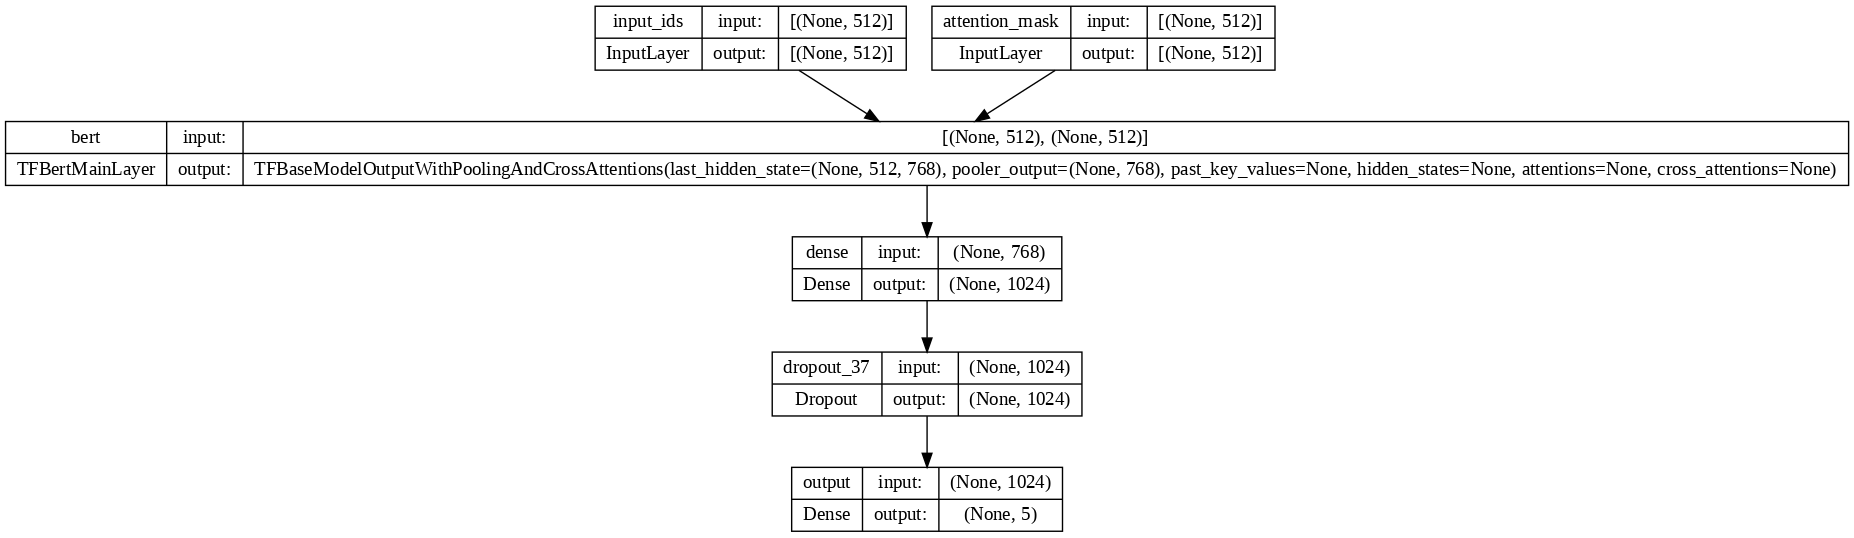

In [ ]:
tf.keras.utils.plot_model(model = bert_model, show_shapes=True, dpi=100, )


In [ ]:
metric=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='Precision'),
        tf.keras.metrics.Recall(name='Recall'),
        tf.keras.metrics.TruePositives(name='TruePositives'),
        tf.keras.metrics.FalsePositives(name='FalsePositives')]
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-5,decay=1e-6,)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
bert_model.compile(optimizer = optimizer, loss = loss, metrics = metric)

In [ ]:
def fit_model(model):
  history = model.fit(
      dataset_train,
      validation_data = dataset_valid,
      epochs = epochs,
      verbose=1,
  )
  return history

In [ ]:
bert_history = fit_model(bert_model)

Epoch 1/3
194/194 [==============================] - 213s 1s/step - loss: 0.4770 - accuracy: 0.8363 - Precision: 0.9228 - Recall: 0.7777 - TruePositives: 1207.0000 - FalsePositives: 101.0000 - val_loss: 0.1283 - val_accuracy: 0.9604 - val_Precision: 0.9604 - val_Recall: 0.9604 - val_TruePositives: 315.0000 - val_FalsePositives: 13.0000
Epoch 2/3
194/194 [==============================] - 210s 1s/step - loss: 0.1348 - accuracy: 0.9671 - Precision: 0.9689 - Recall: 0.9620 - TruePositives: 1493.0000 - FalsePositives: 48.0000 - val_loss: 0.1809 - val_accuracy: 0.9665 - val_Precision: 0.9724 - val_Recall: 0.9665 - val_TruePositives: 317.0000 - val_FalsePositives: 9.0000
Epoch 3/3
194/194 [==============================] - 205s 1s/step - loss: 0.0812 - accuracy: 0.9807 - Precision: 0.9832 - Recall: 0.9800 - TruePositives: 1521.0000 - FalsePositives: 26.0000 - val_loss: 0.0645 - val_accuracy: 0.9756 - val_Precision: 0.9756 - val_Recall: 0.9756 - val_TruePositives: 320.0000 - val_FalsePositive

In [ ]:
#Saving model to google drive
# bert_model_path = os.path.join(Path.FINE_TUNED_MODELS, 'bert/model.h5')
# bert_model.save(bert_model_path)

In [ ]:
# bert_model_path = os.path.join(Path.FINE_TUNED_MODELS, 'bert/model.h5')
# bert_model.load_weights(bert_model_path)

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(['train '+metric, 'val_'+metric])
  plt.show()

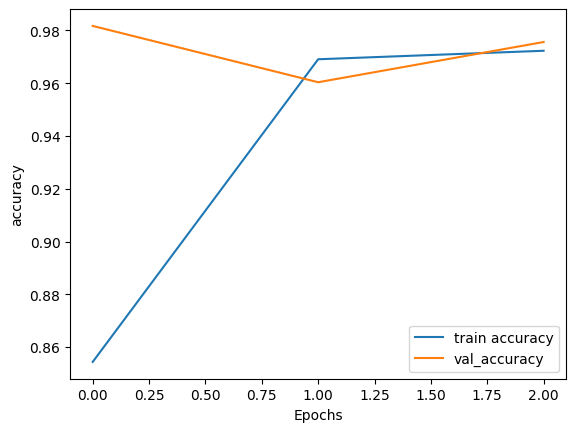

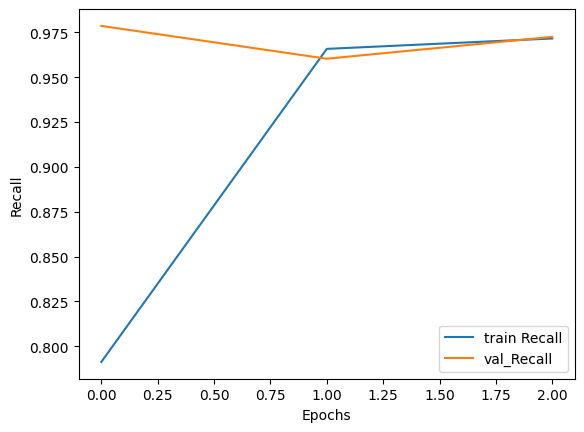

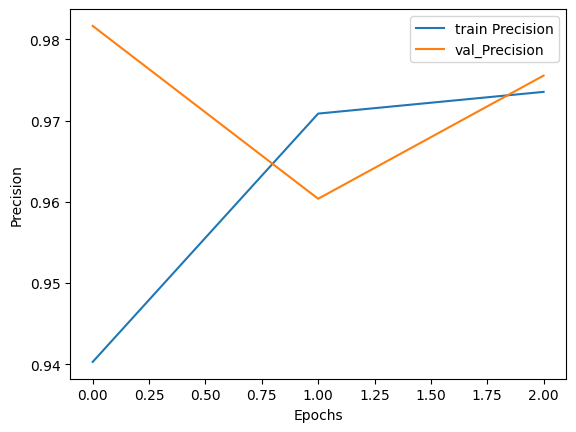

In [ ]:
plot_graphs(bert_history,'accuracy')
plot_graphs(bert_history,'Recall')
plot_graphs(bert_history,'Precision')

In [ ]:
def prediction(model, encoded_test_data, predicted_label):
  classes_list=[]
  tokenizations={'input_ids':tf.cast(encoded_test_data['input_ids'], tf.float64),
                 'attention_mask':tf.cast(encoded_test_data['attention_mask'], tf.float64),
                }
  probabilities = model.predict(tokenizations)
  classes_list = np.argmax(probabilities, axis=1).tolist()
  # classes_list=np.argmax(probabilities)
  # classes_list.append(highest_class)
  test_df[predicted_label]=classes_list
  return test_df

In [ ]:
test_bert_prediction = prediction(bert_model, encoded_test_bert,'bert_label')

11/11 [==============================] - 20s 1s/step


In [ ]:
test_bert_prediction

,category,text,label,bert_label
1679,tech,security warning fbi virus u federal bureau in...,0,0
794,tech,million buy mp3 player u one 10 adult american...,0,0
1037,entertainment,foxx swank take actor award jamie foxx hilary ...,3,3
1963,business,imf agrees fresh turkey funding turkey agreed ...,1,1
1885,entertainment,label withdraws mcfadden video new video forme...,3,3
...,...,...,...,...
2220,business,car pull u retail figure u retail sale fell 03...,1,1
368,business,emi share hit profit warning share music giant...,1,3
536,entertainment,itunes selling band aid song ipod owner downlo...,3,3
472,politics,antiterror plan face first test plan allow hom...,4,4


In [ ]:
test_predictions = test_bert_prediction['bert_label']
test_true_vals = test_bert_prediction['label']
accuracy, precision, recall, f1 = calculate_metrics(test_true_vals, test_predictions)
accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1s.append(f1)

**Fine-Tune XLNET for Text Classification**

XLNet, developed by Google in 2019, is another state-of-the-art language model that differs from BERT in its treatment of word order. While BERT considers words bidirectionally, XLNet models the dependencies between all words in a sentence, allowing it to capture more complex relationships.

In [ ]:
xlnet_tokenizer = get_tokenizer(xlnet_model_name)
encoded_train_xlnet = encode_data(xlnet_tokenizer, train_df)
encoded_val_xlnet = encode_data(xlnet_tokenizer, valid_df)
encoded_test_xlnet = encode_data(xlnet_tokenizer, test_df)
dataset_train = prepare_tensor_dataset(encoded_train_xlnet, train_df)
dataset_valid = prepare_tensor_dataset(encoded_val_xlnet, valid_df)

Getting from xlnet-base-cased ...


In [ ]:
xlnet_model = create_model(xlnet_model_name)
xlnet_model.summary()

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary', 'logits_proj']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tfxl_net_for_sequence_classifi  TFXLNetForSequenceC  117312773  ['input_ids[0][0]',              
 cation_2 (TFXLNetForSequenceCl  lassificationOutput              'attention_mask[0][0]']         
 assification)                  (loss=None, logits=                                               
                                (None, 5),                                                  

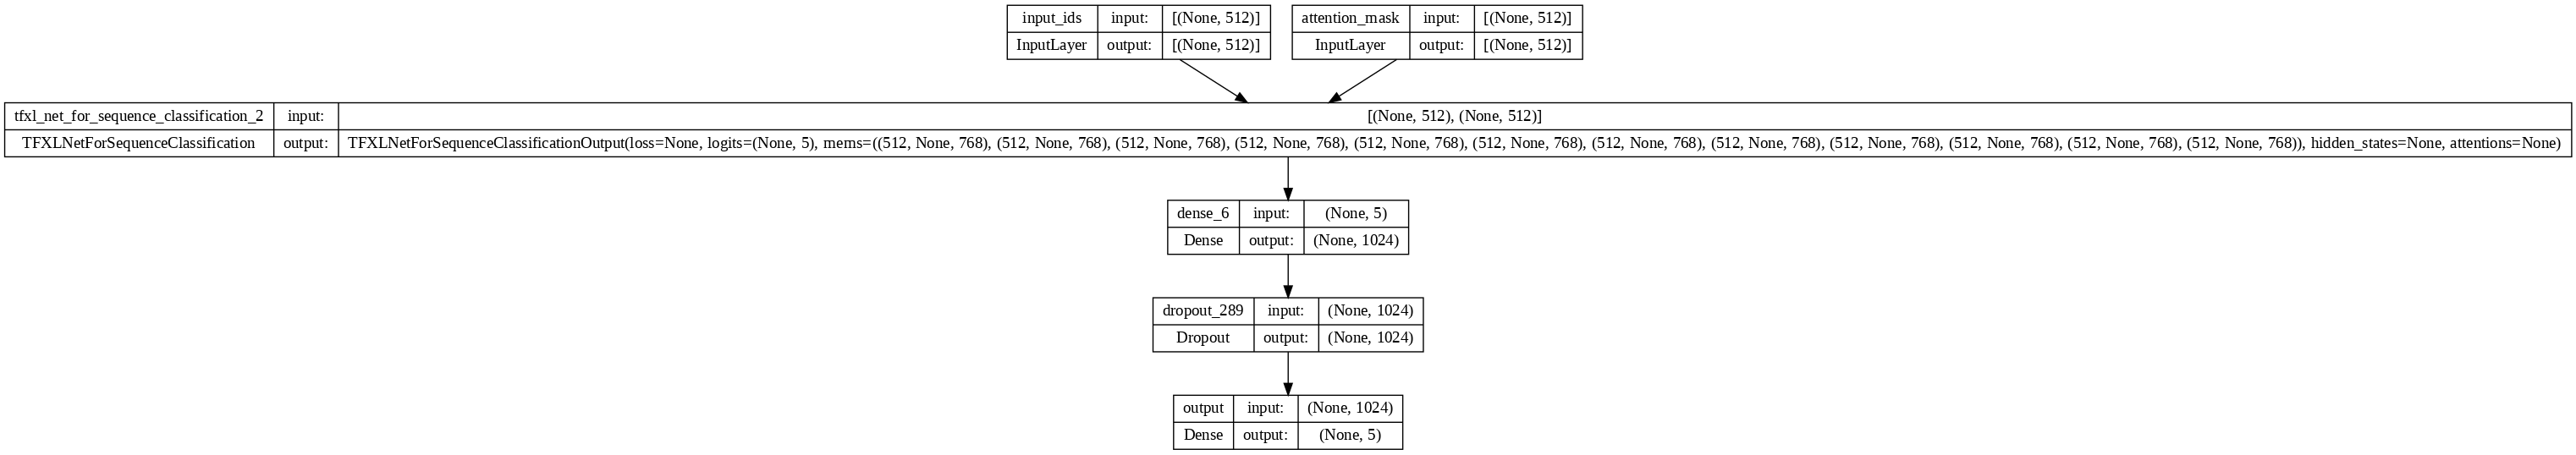

In [ ]:
tf.keras.utils.plot_model(model = xlnet_model, show_shapes=True, dpi=100, )

In [ ]:
xlnet_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-5,decay=1e-6,)

In [ ]:
xlnet_model.compile(optimizer = xlnet_optimizer, loss = loss, metrics = metric)

In [ ]:
xlnet_history = fit_model(xlnet_model)

Epoch 1/3


194/194 [==============================] - 453s 2s/step - loss: 1.3542 - accuracy: 0.3449 - Precision: 0.9412 - Recall: 0.0374 - TruePositives: 112.0000 - FalsePositives: 7.0000 - val_loss: 0.7082 - val_accuracy: 0.9360 - val_Precision: 0.9943 - val_Recall: 0.5274 - val_TruePositives: 173.0000 - val_FalsePositives: 1.0000
Epoch 2/3
194/194 [==============================] - 438s 2s/step - loss: 0.4528 - accuracy: 0.9311 - Precision: 0.9597 - Recall: 0.8280 - TruePositives: 1285.0000 - FalsePositives: 54.0000 - val_loss: 0.2560 - val_accuracy: 0.9543 - val_Precision: 0.9626 - val_Recall: 0.9421 - val_TruePositives: 309.0000 - val_FalsePositives: 12.0000
Epoch 3/3
194/194 [==============================] - 438s 2s/step - loss: 0.2072 - accuracy: 0.9639 - Precision: 0.9670 - Recall: 0.9620 - TruePositives: 1493.0000 - FalsePositives: 51.0000 - val_loss: 0.1093 - val_accuracy: 0.9756 - val_Precision: 0.9786 - val_Recall: 0.9756 - val_TruePositives: 320.0000 - val_FalsePositives: 7.0000


In [ ]:
#Saving model to google drive
xlnet_model_path = os.path.join(Path.FINE_TUNED_MODELS, 'xlnet/model.h5')
xlnet_model.save(xlnet_model_path)

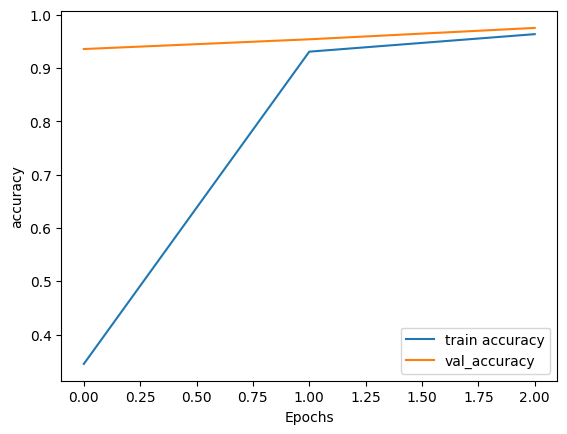

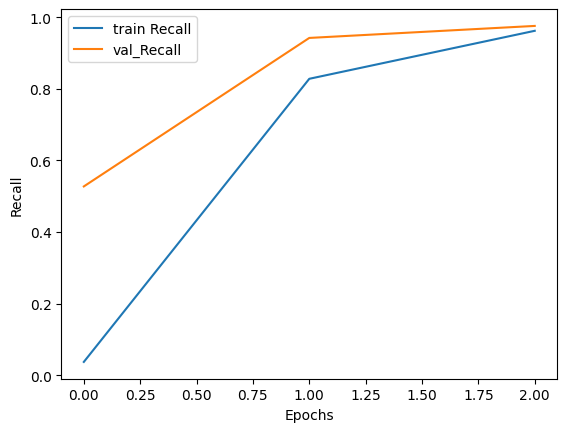

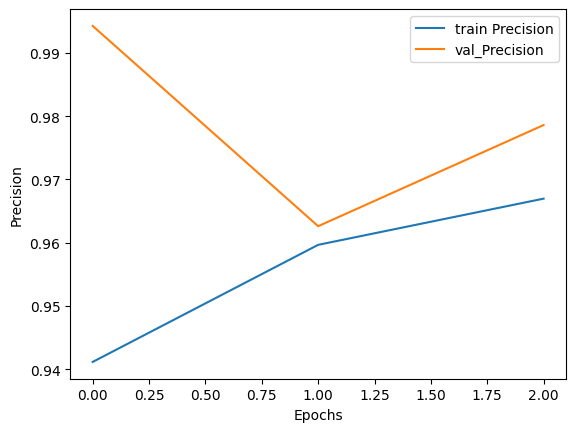

In [ ]:
plot_graphs(xlnet_history,'accuracy')
plot_graphs(xlnet_history,'Recall')
plot_graphs(xlnet_history,'Precision')

In [ ]:
test_xlnet_prediction = prediction(xlnet_model, encoded_test_xlnet, 'xlnet_label')

11/11 [==============================] - 31s 3s/step


In [ ]:
test_xlnet_prediction

,category,text,label,bert_label,distilbert_label,xlnet_label
1679,tech,security warning fbi virus u federal bureau in...,0,0,0,0
794,tech,million buy mp3 player u one 10 adult american...,0,0,0,0
1037,entertainment,foxx swank take actor award jamie foxx hilary ...,3,3,3,3
1963,business,imf agrees fresh turkey funding turkey agreed ...,1,1,1,1
1885,entertainment,label withdraws mcfadden video new video forme...,3,3,3,3
...,...,...,...,...,...,...
2220,business,car pull u retail figure u retail sale fell 03...,1,1,1,1
368,business,emi share hit profit warning share music giant...,1,3,3,1
536,entertainment,itunes selling band aid song ipod owner downlo...,3,3,3,0
472,politics,antiterror plan face first test plan allow hom...,4,4,4,4


In [ ]:
xlnet_test_predictions = test_xlnet_prediction['xlnet_label']
xlnet_test_true_vals = test_xlnet_prediction['label']
xlnet_accuracy, xlnet_precision, xlnet_recall, xlnet_f1 = calculate_metrics(xlnet_test_true_vals, xlnet_test_predictions)
accuracies.append(xlnet_accuracy)
precisions.append(xlnet_precision)
recalls.append(xlnet_recall)
f1s.append(xlnet_f1)

**Fine-Tune DistilBert for Text Classification**

DistilBERT, introduced by Hugging Face, is a distilled version of BERT that retains much of its performance while significantly reducing its size and computational requirements.

In [ ]:
distilbert_tokenizer = get_tokenizer(distilbert_model_name)
encoded_train_distilbert = encode_data(distilbert_tokenizer, train_df)
encoded_val_distilbert = encode_data(distilbert_tokenizer, valid_df)
encoded_test_distilbert = encode_data(distilbert_tokenizer, test_df)
dataset_train = prepare_tensor_dataset(encoded_train_distilbert, train_df)
dataset_valid = prepare_tensor_dataset(encoded_val_distilbert, valid_df)

Getting from distilbert-base-uncased ...


In [ ]:
distilbert_model = create_model(distilbert_model_name)
distilbert_model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model_4 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 512, 768),                                                   
                                 hidden_states=None                                         

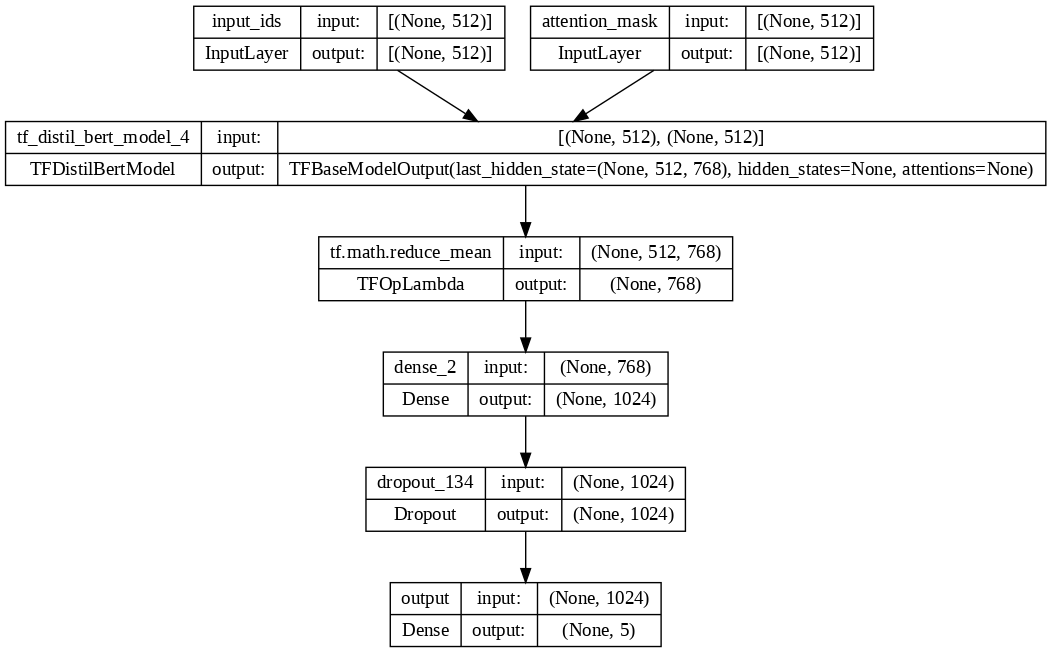

In [ ]:
tf.keras.utils.plot_model(model = distilbert_model, show_shapes=True, dpi=100, )

In [ ]:
distilbert_model.compile(optimizer = optimizer, loss = loss, metrics = metric)

In [ ]:
distilbert_history = fit_model(distilbert_model)

Epoch 1/3
194/194 [==============================] - 107s 522ms/step - loss: 0.3831 - accuracy: 0.9101 - Precision: 0.9446 - Recall: 0.8888 - TruePositives: 1671.0000 - FalsePositives: 98.0000 - val_loss: 0.0978 - val_accuracy: 0.9726 - val_Precision: 0.9725 - val_Recall: 0.9695 - val_TruePositives: 318.0000 - val_FalsePositives: 9.0000
Epoch 2/3
194/194 [==============================] - 104s 536ms/step - loss: 0.1048 - accuracy: 0.9729 - Precision: 0.9761 - Recall: 0.9723 - TruePositives: 1509.0000 - FalsePositives: 37.0000 - val_loss: 0.0747 - val_accuracy: 0.9787 - val_Precision: 0.9846 - val_Recall: 0.9756 - val_TruePositives: 320.0000 - val_FalsePositives: 5.0000
Epoch 3/3
194/194 [==============================] - 104s 536ms/step - loss: 0.0401 - accuracy: 0.9897 - Precision: 0.9903 - Recall: 0.9897 - TruePositives: 1536.0000 - FalsePositives: 15.0000 - val_loss: 0.1035 - val_accuracy: 0.9665 - val_Precision: 0.9665 - val_Recall: 0.9665 - val_TruePositives: 317.0000 - val_FalseP

In [ ]:
#Saving model to google drive
distilbert_model_path = os.path.join(Path.FINE_TUNED_MODELS, 'distilbert/model.h5')
distilbert_model.save(distilbert_model_path)

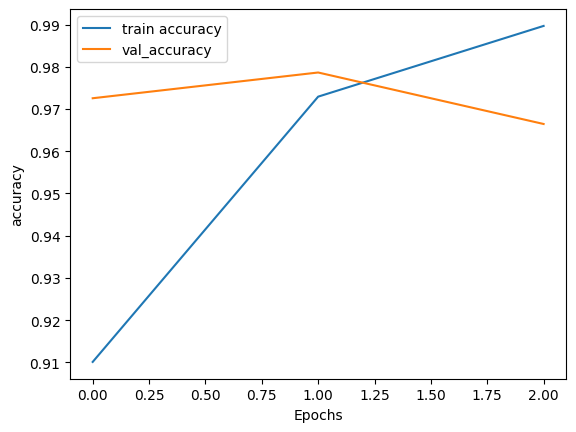

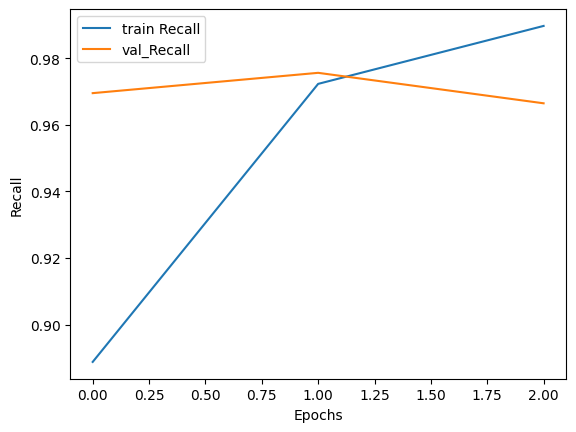

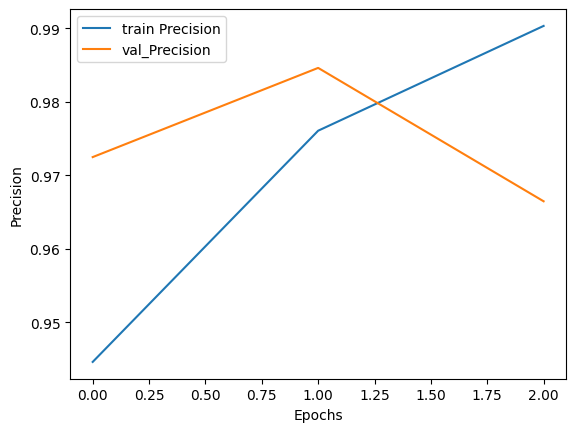

In [ ]:
plot_graphs(distilbert_history,'accuracy')
plot_graphs(distilbert_history,'Recall')
plot_graphs(distilbert_history,'Precision')

In [ ]:
test_distilbert_prediction = prediction(distilbert_model, encoded_test_distilbert, 'distilbert_label')

11/11 [==============================] - 8s 577ms/step


In [ ]:
test_distilbert_prediction

,category,text,label,bert_label,distilbert_label
1679,tech,security warning fbi virus u federal bureau in...,0,0,0
794,tech,million buy mp3 player u one 10 adult american...,0,0,0
1037,entertainment,foxx swank take actor award jamie foxx hilary ...,3,3,3
1963,business,imf agrees fresh turkey funding turkey agreed ...,1,1,1
1885,entertainment,label withdraws mcfadden video new video forme...,3,3,3
...,...,...,...,...,...
2220,business,car pull u retail figure u retail sale fell 03...,1,1,1
368,business,emi share hit profit warning share music giant...,1,3,3
536,entertainment,itunes selling band aid song ipod owner downlo...,3,3,3
472,politics,antiterror plan face first test plan allow hom...,4,4,4


In [ ]:
distilbert_test_predictions = test_distilbert_prediction['distilbert_label']
distilbert_test_true_vals = test_distilbert_prediction['label']
distilbert_accuracy, distilbert_precision, distilbert_recall, distilbert_f1 = calculate_metrics(distilbert_test_true_vals, distilbert_test_predictions)
accuracies.append(distilbert_accuracy)
precisions.append(distilbert_precision)
recalls.append(distilbert_recall)
f1s.append(distilbert_f1)

In [ ]:
print('accuracy(BERT, Distilbert, XLNet)  :: ', accuracies)
print('precision(BERT, Distilbert, XLNet) :: ', precisions)
print('recall(BERT, Distilbert, XLNet)    :: ', recalls)
print('F1-score(BERT, Distilbert, XLNet)  :: ', f1s)

accuracy(BERT, Distilbert, XLNet)  ::  [0.9760479041916168, 0.9520958083832335, 0.9700598802395209]
precision(BERT, Distilbert, XLNet) ::  [0.9762350161615283, 0.9519133802886663, 0.9691907411662278]
recall(BERT, Distilbert, XLNet)    ::  [0.9756338211288156, 0.9558889386475593, 0.9715882967607106]
F1-score(BERT, Distilbert, XLNet)  ::  [0.9758609206001821, 0.9515947043534071, 0.9700065493185693]


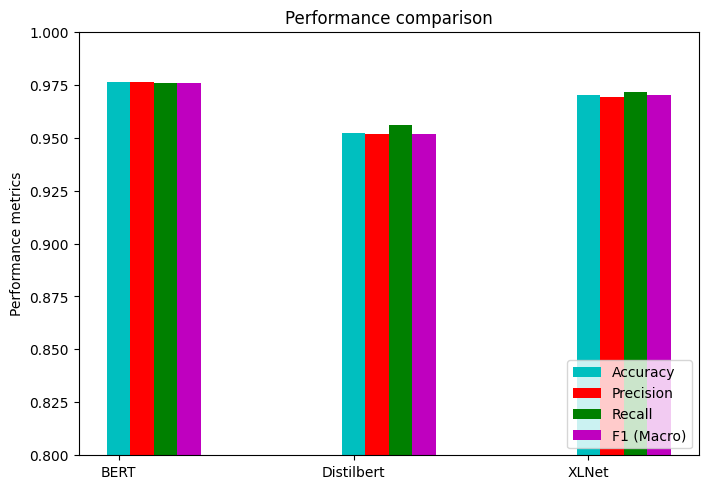

In [ ]:
plot_metrics(accuracies, precisions, recalls, f1s, ('BERT', 'Distilbert', 'XLNet'))

# Hugging face Sequence classification models

In this section, I used three pre-trained models from Transformers library (PyTorch implementations) which they are fine-tuned for the task of sequence classification. These models come with a linear layer on top of the pooled output, designed for binary or multilabel classification tasks. The linear layer takes the final hidden state of the model (the representation of the input sequence) as input and outputs the logits (prediction scores) for the task.

In [ ]:
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [ ]:
tr_accuracies = []
tr_precisions = []
tr_recalls = []
tr_f1s= []

In [ ]:
class TransformerModel:
    def __init__(self, model_name, num_labels = 5, epochs = 3, batch_size = 3, seed = 42):
        self.model_name = model_name
        self.num_labels = num_labels
        self.epochs = epochs
        self.batch_size = batch_size
        self.seed = seed
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.tokenizer = None
        self.dataset_train = None
        self.dataset_val = None
        self.dataset_test = None
        self.dataloader_train = None
        self.dataloader_val = None
        self.dataloader_test = None
        self.scheduler = None
        self.optimizer = None

        self.get_model_tokenizer()
        self.encoded_data_train = self.encode_data(train_df)
        self.encoded_data_val = self.encode_data(valid_df)
        self.encoded_data_test = self.encode_data(test_df)
        self.prepare_tensor_dataset()
        self.load_batch_data()
        self.set_optimizer()
        set_seed(self.seed)
        self.train()

    def get_model_tokenizer(self):
        print(f"Getting from {self.model_name} ...")
        print(f"Device: {self.device}")
        if 'xlnet' in self.model_name:
            self.tokenizer = XLNetTokenizer.from_pretrained(self.model_name)
            self.model = XLNetForSequenceClassification.from_pretrained(self.model_name,
                                                                        num_labels=self.num_labels,
                                                                        output_attentions=False,
                                                                        output_hidden_states=False)
        elif 'distilbert' in self.model_name:
            self.tokenizer = DistilBertTokenizer.from_pretrained(self.model_name)
            self.model = DistilBertForSequenceClassification.from_pretrained(self.model_name,
                                                      num_labels=self.num_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
        elif 'bert' in self.model_name:
            self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
            self.model = BertForSequenceClassification.from_pretrained(self.model_name,
                                                      num_labels=self.num_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
        self.model.to(self.device)
        return self

    def encode_data(self, data_df):
        encoded_data = self.tokenizer.batch_encode_plus(
        data_df.text.values,
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        truncation = True,
        max_length=max_length,
        return_tensors='pt'
        )
        return encoded_data

    def prepare_tensor_dataset(self):
        input_ids_train = self.encoded_data_train['input_ids']
        attention_masks_train = self.encoded_data_train['attention_mask']
        labels_train = torch.tensor(train_df.label.values)
        self.dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)

        input_ids_val = self.encoded_data_val['input_ids']
        attention_masks_val = self.encoded_data_val['attention_mask']
        labels_val = torch.tensor(valid_df.label.values)
        self.dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

        input_ids_test = self.encoded_data_test['input_ids']
        attention_masks_test = self.encoded_data_test['attention_mask']
        labels_test = torch.tensor(test_df.label.values)
        self.dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
        return self


    def load_batch_data(self):
        self.dataloader_train = DataLoader(self.dataset_train,
                                           sampler=RandomSampler(self.dataset_train),
                                           batch_size=self.batch_size)

        self.dataloader_val = DataLoader(self.dataset_val,
                                         sampler=SequentialSampler(self.dataset_val),
                                         batch_size=self.batch_size)

        self.dataloader_test = DataLoader(self.dataset_test,
                                          sampler=SequentialSampler(self.dataset_test),
                                          batch_size=self.batch_size)
        return self

    def set_optimizer(self):
        self.optimizer = AdamW(self.model.parameters(),
                          lr=1e-5,
                          eps=1e-8)
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(self.dataloader_train)*self.epochs)
        return self

    def evaluate(self, dataloader):
        self.model.eval()
        loss_total = 0
        predictions, true_vals = [], []
        for batch in dataloader:
            batch = tuple(b.to(self.device) for b in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'labels':         batch[2],
                     }
            with torch.no_grad():
                outputs = self.model(**inputs)
            loss = outputs[0]
            logits = outputs[1]
            loss_total += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = inputs['labels'].cpu().numpy()
            predictions.append(logits)
            true_vals.append(label_ids)

        loss_avg = loss_total/len(dataloader)
        predictions = np.concatenate(predictions, axis=0)
        true_vals = np.concatenate(true_vals, axis=0)

        return loss_avg, predictions, true_vals


    def train(self):
        for epoch in tqdm(range(1, self.epochs+1)):
            self.model.train()
            loss_train_total = 0
            progress_bar = tqdm(self.dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
            for batch in progress_bar:
                self.model.zero_grad()
                batch = tuple(b.to(self.device) for b in batch)
                inputs = {'input_ids':      batch[0],
                          'attention_mask': batch[1],
                          'labels':         batch[2],
                         }

                outputs = self.model(**inputs)
                loss = outputs[0]
                loss_train_total += loss.item()
                loss.backward()

                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

                self.optimizer.step()
                self.scheduler.step()

                progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

            # model_path = os.path.join(Path.TRANSFORMER_MODELS, f'{self.model_name}/epoch_{epoch}.model')
            # torch.save(self.model.state_dict(), model_path)

            tqdm.write(f'\nEpoch {epoch}')
            loss_train_avg = loss_train_total/len(self.dataloader_train)
            tqdm.write(f'Training loss: {loss_train_avg}')

            val_loss, val_predictions, val_true_vals = self.evaluate(self.dataloader_val)
            val_predictions = np.argmax(val_predictions, axis=1).flatten()
            val_true_vals = val_true_vals.flatten()
            accuracy, precision, recall, f1 = calculate_metrics(val_true_vals, val_predictions)
            tqdm.write(f'Validation loss: {val_loss}')
            tqdm.write(f'Validation Accuracy: {accuracy}')
            tqdm.write(f'Validation Precision: {precision}')
            tqdm.write(f'Validation Recall: {recall}')
            tqdm.write(f'Validation F1 Score (Macro): {f1}')


        test_loss, test_predictions, test_true_vals = self.evaluate(self.dataloader_test)
        test_predictions = np.argmax(test_predictions, axis=1).flatten()
        test_true_vals = test_true_vals.flatten()
        accuracy, precision, recall, f1 = calculate_metrics(test_true_vals, test_predictions)
        tr_accuracies.append(accuracy)
        tr_precisions.append(precision)
        tr_recalls.append(recall)
        tr_f1s.append(f1)


In [ ]:
bert = TransformerModel(bert_model_name, num_labels = 5, epochs = 3, batch_size = 8, seed = 42)

Getting from bert-base-uncased ...
Device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7626940439908932
Validation loss: 0.13606032267922447
Validation Accuracy: 0.9760479041916168
Validation Precision: 0.9782203389830508
Validation Recall: 0.9752130325814535
Validation F1 Score (Macro): 0.9764621796185642


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.099138465600136
Validation loss: 0.06406779862230733
Validation Accuracy: 0.9820359281437125
Validation Precision: 0.9818592896174863
Validation Recall: 0.9821490507878892
Validation F1 Score (Macro): 0.9819552658741566


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.05013106932433752
Validation loss: 0.05593431519255752
Validation Accuracy: 0.9820359281437125
Validation Precision: 0.9814864644487932
Validation Recall: 0.9828508051738541
Validation F1 Score (Macro): 0.9819470019399376


DistilBert is a smaller version of BERT that is much faster and cheaper.

In [ ]:
distilbert = TransformerModel(distilbert_model_name, num_labels = 5, epochs = 3, batch_size = 8, seed = 42)

Getting from distilbert-base-uncased ...
Device: cuda


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7819935833032314
Validation loss: 0.19275978455940881
Validation Accuracy: 0.9760479041916168
Validation Precision: 0.9784620213433772
Validation Recall: 0.9747137959842134
Validation F1 Score (Macro): 0.9761742732058842


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.12930964640317819
Validation loss: 0.07630306415792022
Validation Accuracy: 0.9820359281437125
Validation Precision: 0.9818658474142345
Validation Recall: 0.9823077809466193
Validation F1 Score (Macro): 0.9820104581351294


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0646555581345008
Validation loss: 0.06995072025096133
Validation Accuracy: 0.9850299401197605
Validation Precision: 0.9849892473118281
Validation Recall: 0.9857560568086884
Validation F1 Score (Macro): 0.9852987949191185


In [ ]:
XLNet = TransformerModel(xlnet_model_name, num_labels = 5, epochs = 3, batch_size = 8, seed = 42)

Getting from xlnet-base-cased ...
Device: cuda


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.425432334236132
Validation loss: 0.08170574269856193
Validation Accuracy: 0.9700598802395209
Validation Precision: 0.9738242891279659
Validation Recall: 0.9681620718462824
Validation F1 Score (Macro): 0.9701583722166912


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0889663491714507
Validation loss: 0.09021290889636259
Validation Accuracy: 0.9820359281437125
Validation Precision: 0.9824774907799763
Validation Recall: 0.9817647567193847
Validation F1 Score (Macro): 0.9819946204249831


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.04295570016211758
Validation loss: 0.06536907944731259
Validation Accuracy: 0.9850299401197605
Validation Precision: 0.9850594227504246
Validation Recall: 0.9849393598939878
Validation F1 Score (Macro): 0.9849190231458904


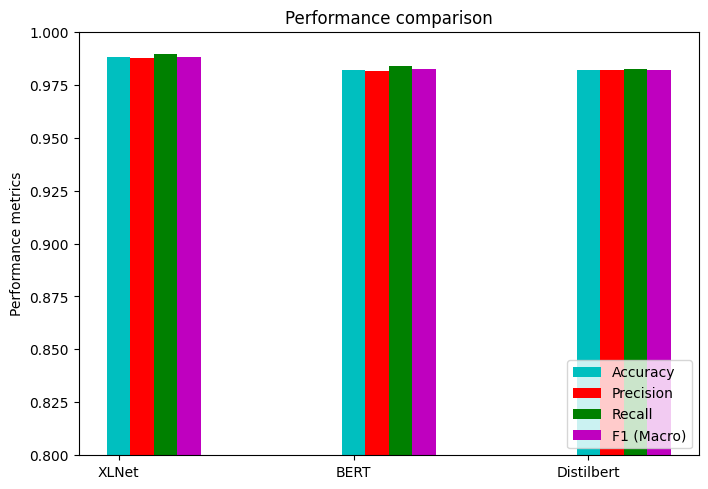

In [ ]:
plot_metrics(tr_accuracies, tr_precisions, tr_recalls, tr_f1s, ('XLNet', 'BERT', 'Distilbert'))

In [ ]:
print(tr_accuracies)
print(tr_precisions)
print(tr_recalls)
print(tr_f1s)

[0.9880239520958084, 0.9820359281437125, 0.9820359281437125]
[0.9874905422446407, 0.9816738931403203, 0.9818302587068765]
[0.9896103896103895, 0.983787180561374, 0.982200376560777]
[0.9882893646558643, 0.9824730916899851, 0.9819662441668487]


# Comparision with SOTA results
In this section, I present the performance of various state-of-the-art approaches for topic classification on the BBC News dataset. These approaches leverage advanced techniques in natural language processing and machine learning to achieve high accuracy and robust performance. By comparing our results against the SOTA methods, we can assess the effectiveness of our proposed model and gain insights into the current state of topic classification research on this benchmark dataset.

**Machine learning approaches**

[Decision Tree](https://https://www.kaggle.com/code/ksavleen/bbc-news-naive-bayes-decision-trees-random-forests) ====> (Accuracy: 0.678)

[TF-IDF + Feature Selection KNN](https://https://github.com/ross-abramson/Doc2Vec-Classification)	====> (Accuracy: 0.885)

[Document Embedding BoW + KNN](https://https://https://github.com/ross-abramson/Doc2Vec-Classification)		====> (Accuracy: 0.955)

**Deep learning approaches**

[RNN](https://https://www.cai.sk/ojs/index.php/cai/article/view/2022_1_98/1138)
====> (Accuracy: 0.946, Macro F1: 0.945)

[LSTM](https://https://github.com/mmalam3/BBC-News-Classification-using-LSTM-and-TensorFlow/blob/main/bbc_news_classification.ipynb) ====> (Accuracy: 0.932)

[CNN](https://https://www.cai.sk/ojs/index.php/cai/article/view/2022_1_98/1138)
====> (Accuracy: 0.961, Macro F1: 0.960)

**Hugging face models**

There are a number of fine-tuned versions of Transformers models specifically trained on the BBC News dataset.

Here you can find a list of them:

[DistilRoberta](https://https://huggingface.co/AyoubChLin/DistilRoberta-bbc_news) ====> (Accuracy: 0.985, Macro F1: 0.984)

[XLMRoberta-large](https://https://huggingface.co/AyoubChLin/XLMRoberta-large-bbc_news)  ====> (Accuracy: 0.978, Macro F1: 0.978)

[BERT-Large](https://https://huggingface.co/AyoubChLin/BERT-Large_BBC_news)  ====> (Accuracy: 0.979, Macro F1: 0.979)

[Albert](https://https://huggingface.co/AyoubChLin/Albert-bbc-news)  ====> (Accuracy: 0.978, Macro F1: 0.978)

[longformer](https://huggingface.co/AyoubChLin/longformer_bbc_news) ====> (Accuracy: 0.971, Macro F1: 0.970)

[delberta_large](https://https://huggingface.co/AyoubChLin/delberta_large_bbc_news)  ====> (Accuracy: 0.980, Macro F1: 0.980)